## NYC Neighborhood Crime/Safety: 

# NYC Neighborhood Residential Real Estate Analysis
### Applying Data Science Tools to  

    Josh Grasso | joshgrasso@gmail.com

Which NYC neighborhoods are the next great residential real estate investment and development stories? 

   



### Neighborhood Crime/Safety: via NYPD Shooting Incidents / Gun Violence

When contemplating moving to an up-and-coming neighborhood, a constraint that often presents itself is “would you feel safe walking home at night from the subway station?” A similar line of thought comes up in stories from old-time NYC residents about the dramatic development some neighborhoods have undergone – Lower East Side, Hells Kitchen, and Prospect Heights for example. “You would never think of going into these neighborhoods when I was a kid!” But now they are safe, and home prices have boomed. 

A neighborhood’s safety or crime should be a useful feature in understanding relative home prices, with consumers paying a premium for safer neighborhoods. To develop a metric to test for this, I use a dataset from the NYPD for all shooting incidents in NYC from 2006 to 2019. Each “incident” pertains to a single victim of gun violence, thus, if there are multiple victims of the same shooter/shooting – it counts as more than one “incident.” The NYPD also makes a dataset on all arrests available – which could be an area of additional research beyond just shootings. Overall, gun violence in NYC has trended down over this recent history, with the total number of shootings down over 50% across NYC since 2006. Also more than one third of NYC neighborhoods have fewer than 1 shooting incident per year. However, the curve is non-linear with the worst neighborhoods experiencing 60 shootings per year (more than one a week) – Brownsville and Bedford Stuyvesant, both in Brooklyn. The worst year in the dataset is Brownsville in 2007 – with 109 shooting incidents, 2 per week. 

To match each shooting incident with it’s neighborhood, I used the latitude/longitude coordinates for each shooting, as well as latitude/longitude for each neighborhood, to match the shooting to the closest neighborhood. I used an implementation of the Haversine formula found on Sack Overflow – and checked the robustness of the results using the Google Maps Directions API for ~50 shootings.


In [1]:
import numpy as np
import pandas as pd
import requests

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn')  
sns.set()

from datetime import datetime
today = datetime.now()
month,day,year = today.month,today.day,today.year

In [2]:
from pathlib import Path
home_path = Path.home() / 'Jupyter' / 'Real_Estate'

In [3]:
# NYPD Shooting Incident Data (Historic)
# Source: https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Historic-/833y-fsy8

nyc_shootings_raw_df = pd.read_csv('NYPD_Shooting_Incident_Data__Historic_.csv')


# Also Available: 
# NYPD Arrests Data (Historic)
# Source: https://data.cityofnewyork.us/Public-Safety/NYPD-Arrests-Data-Historic-/8h9b-rp9u

# 2010 - 2016 School Safety Report
# Source: https://data.cityofnewyork.us/Education/2010-2016-School-Safety-Report/qybk-bjjc

In [6]:
# Parse Data: 
nyc_shootings_raw_df['OCCUR_DATE'] = pd.to_datetime(nyc_shootings_raw_df['OCCUR_DATE']) # .isna().sum()   # 0
nyc_shootings_raw_df['BORO'] = (nyc_shootings_raw_df['BORO'].str.title()  # BORO to Tile-case
                                .replace({'Staten Island': 'Staten_Island'}))


In [7]:
nyc_shootings_raw_df.head()


,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,201575314,2019-08-23,22:10:00,Queens,103,0.0,NaN,False,NaN,NaN,NaN,25-44,M,BLACK,1037451,193561,40.697805,-73.808141,POINT (-73.80814071699996 40.697805308000056)
1,205748546,2019-11-27,15:54:00,Bronx,40,0.0,NaN,False,<18,M,BLACK,25-44,F,BLACK,1006789,237559,40.818700,-73.918571,POINT (-73.91857061799993 40.81869973000005)
2,193118596,2019-02-02,19:40:00,Manhattan,23,0.0,NaN,False,18-24,M,WHITE HISPANIC,18-24,M,BLACK HISPANIC,999347,227795,40.791916,-73.945480,POINT (-73.94547965999999 40.791916091000076)
3,204192600,2019-10-24,00:52:00,Staten_Island,121,0.0,PVT HOUSE,True,25-44,M,BLACK,25-44,F,BLACK,938149,171781,40.638064,-74.166108,POINT (-74.16610830199996 40.63806398200006)
4,201483468,2019-08-22,18:03:00,Bronx,46,0.0,NaN,False,25-44,M,BLACK HISPANIC,18-24,M,BLACK,1008224,250621,40.854547,-73.913339,POINT (-73.91333944399999 40.85454734900003)


In [19]:
# Neighborhoods Names
# https://www1.nyc.gov/site/planning/data-maps/open-data.page

neighborhood_url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/Neighborhood_Names/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
resp = requests.get(neighborhood_url)
neighborhood_json = resp.json()

neighborhood_ids_list = []
neighborhood_details_list = []

for neighborhood_dict in neighborhood_json['features']:
    neighborhood_ids_list.append(neighborhood_dict['id']) 
    
    d = {}
    d['ID'] = neighborhood_dict['id']
    # Neighborhood instead of name? 
    d['Name'] = neighborhood_dict['properties']['Name']
    d['Borough'] = neighborhood_dict['properties']['Borough']
    d['Lat'] = neighborhood_dict['geometry']['coordinates'][1]
    d['Long'] = neighborhood_dict['geometry']['coordinates'][0]
    
    neighborhood_details_list.append(d)

neighborhood_df = pd.DataFrame.from_dict(neighborhood_details_list)
neighborhood_df['Borough'] = neighborhood_df['Borough'].replace({'Staten Island': 'Staten_Island'})
neighborhood_df = neighborhood_df.rename(columns={'Name': 'Neighborhood'})


In [20]:
neighborhood_df

,ID,Neighborhood,Borough,Lat,Long
0,1,Wakefield,Bronx,40.894713,-73.847202
1,2,Co-op City,Bronx,40.874302,-73.829941
2,3,Eastchester,Bronx,40.887564,-73.827808
3,4,Fieldston,Bronx,40.895446,-73.905644
4,5,Riverdale,Bronx,40.890843,-73.912587
...,...,...,...,...,...
301,302,Stapleton,Staten_Island,40.626936,-74.077903
302,303,Rosebank,Staten_Island,40.615313,-74.069807
303,304,West Brighton,Staten_Island,40.631887,-74.107183
304,305,Grymes Hill,Staten_Island,40.624193,-74.087250


In [12]:
# Add Rikers Island: 
# "All shooting incidents occurring within the jurisdiction of the Department of Correction 
# have been geo-coded as occurring on Riker’s Island."

# Destinations: 
place_id_dict = {'Rikers Island': 'ChIJ395GkHD1wokRt6VeJ06Nc3k'}
# Source: https://developers.google.com/maps/documentation/javascript/examples/places-placeid-finder

In [13]:
# Google Maps:
# Call My Google API Key:  Next-step: Write and save into a .py file and call the file
MyGoogleAPIKey_path = Path.home() / 'Jupyter' / Path('My_Google_API_Key.txt')
if MyGoogleAPIKey_path.is_file():
    MyGoogleAPIKey_file = open(MyGoogleAPIKey_path, 'rt')
    my_gmaps_key = MyGoogleAPIKey_file.read()
    MyGoogleAPIKey_file.close()
else:
    print('Error: File not found')

Rikers Island 

From the metadata, "all shooting incidents occurring within the jurisdiction of the Department of Correction have been geo-coded as occurring on Riker’s Island." Therefore, I used Google Maps Directions API to get the latitude/longitude of Rikers Island, and make sure that shootings that occur in a correctional institution are not incorrectly allocated to the neighborhoods surrounding Rikers Island in Queens and the Bronx. There ended up being none anyway. 

In [32]:
def gmaps_places(my_gmaps_key, place_id='ChIJhRwB-yFawokRi0AhGH87UTc', 
                 fields=['address_component','name','geometry']):
    # Source: https://developers.google.com/maps/documentation/places/web-service/details
    
    # Build URL:
    gmaps_url = 'https://maps.googleapis.com/maps/api/place/details/json?'
    
    gmaps_url += "place_id={}".format(place_id)
    gmaps_url += "&fields={}".format(','.join(fields))
    gmaps_url += "&key={}".format(my_gmaps_key)
    
    return requests.get(gmaps_url).json()


gmaps_rikers_island_json = gmaps_places(my_gmaps_key, place_id=place_id_dict['Rikers Island'], 
                                        fields=['address_component','name','geometry'])

# gmaps_rikers_island_json['result']['geometry']['location'] # ['lat'] # ['lng']

# neighborhood_df.columns  # ['ID', 'Neighborhood', 'Borough', 'Lat', 'Long']



rikers_island_dict = {'ID': 999,
                      'Neighborhood': 'Rikers_Island', 
                      'Borough': 'Rikers_Island', 
                      'Lat': gmaps_rikers_island_json['result']['geometry']['location']['lat'], 
                      'Long': gmaps_rikers_island_json['result']['geometry']['location']['lng']}

neighborhood_df = neighborhood_df.append(rikers_island_dict, ignore_index=True)

In [21]:
# Hardcoded:
"""
rikers_island_dict = {'ID': 999,
                      'Neighborhood': 'Rikers_Island', 
                      'Borough': 'Rikers_Island', 
                      'Lat': 40.793128, 
                      'Long': -73.886010}
neighborhood_df = neighborhood_df.append(rikers_island_dict, ignore_index=True)
"""

In [22]:
neighborhood_df

,ID,Neighborhood,Borough,Lat,Long
0,1,Wakefield,Bronx,40.894713,-73.847202
1,2,Co-op City,Bronx,40.874302,-73.829941
2,3,Eastchester,Bronx,40.887564,-73.827808
3,4,Fieldston,Bronx,40.895446,-73.905644
4,5,Riverdale,Bronx,40.890843,-73.912587
...,...,...,...,...,...
302,303,Rosebank,Staten_Island,40.615313,-74.069807
303,304,West Brighton,Staten_Island,40.631887,-74.107183
304,305,Grymes Hill,Staten_Island,40.624193,-74.087250
305,306,Todt Hill,Staten_Island,40.597077,-74.111330


In [ ]:
# Map Lat/Long to Neighborhood
# ['Latitude','Longitude']

# Check out Presinct - to - Neighborhood relationship

In [16]:
# Calc Distance: 
# Compare this to the Google Maps results? 

import math

def deg2rad(deg):
    return deg * (math.pi/180)

def getDistanceFromLatLonInKm(lat1,lon1,lat2,lon2):
    R = 6371;  # Radius of the earth in km
    dLat = deg2rad(lat2-lat1)  # deg2rad below
    dLon = deg2rad(lon2-lon1) 
    a = (math.sin(dLat/2) * math.sin(dLat/2) 
             + math.cos(deg2rad(lat1)) * math.cos(deg2rad(lat2)) * math.sin(dLon/2) * math.sin(dLon/2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a)); 
    d = R * c  # Distance in km
    return d / 1.609344  # km to Miles

# Source: https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula


In [28]:
# Map closest Neighborhood to each Shooting:

mapped_neighborhoods_dict = {}  # Key: Shooting_Index, Value: ('Borough','Name')
by_shooting_all_deighborhood_dist_list = []  # List of df's with distanace from shooting to each neighborhood 

# Outer Loop: Shooting Incidents
for shooting_index in nyc_shootings_raw_df.index:
    start_lat = nyc_shootings_raw_df.iloc[shooting_index]['Latitude']
    start_long = nyc_shootings_raw_df.iloc[shooting_index]['Longitude']
    
    distances_dict = {}
    # Vectorized Inner Loop: Calc dist from shooting to each Neighborhood
    incident_df = (neighborhood_df.join(neighborhood_df.apply(lambda x: 
                                                              getDistanceFromLatLonInKm(start_lat,start_long,
                                                                                        x['Lat'],x['Long']),
                                                              axis=1)
                                        .to_frame(name='Distance_miles'))
                   .sort_values('Distance_miles', ascending=True))
    
    by_shooting_all_deighborhood_dist_list.append(incident_df)
    mapped_neighborhoods_dict[shooting_index] = incident_df.loc[incident_df['Distance_miles'].idxmin()]
mapped_neighborhoods_df = pd.DataFrame.from_dict(mapped_neighborhoods_dict, orient='index') 

In [29]:
mapped_neighborhoods_df

,ID,Neighborhood,Borough,Lat,Long,Distance_miles
0,263,Jamaica Center,Queens,40.704666,-73.796903,0.755762
1,178,Concourse Village,Bronx,40.824789,-73.915848,0.444145
2,118,East Harlem,Manhattan,40.792258,-73.944184,0.071785
3,53,Arlington,Staten_Island,40.635333,-74.165106,0.195856
4,24,University Heights,Bronx,40.855735,-73.910417,0.173369
...,...,...,...,...,...,...
21621,115,Central Harlem,Manhattan,40.815984,-73.943213,0.568264
21622,38,Mott Haven,Bronx,40.806247,-73.916101,0.191305
21623,251,Erasmus,Brooklyn,40.646934,-73.948179,0.078369
21624,171,Manhattan Valley,Manhattan,40.797315,-73.964288,0.171331


In [30]:
len(nyc_shootings_raw_df['INCIDENT_KEY'].unique())

17031

In [81]:
# Where there any in Correctional Facilities? 
mapped_neighborhoods_df[mapped_neighborhoods_df['Neighborhood'] == 'Rikers_Island']

,ID,Neighborhood,Borough,Lat,Long,Distance_miles


In [31]:
nyc_shootings_pivot_df = (nyc_shootings_raw_df[['OCCUR_DATE', 'BORO']]
                          .join(mapped_neighborhoods_df[['Borough', 'Neighborhood', 'Distance_miles']]))

# ['INCIDENT_KEY', 'OCCUR_DATE', 'OCCUR_TIME', 'BORO', 'PRECINCT', 
# 'JURISDICTION_CODE', 'LOCATION_DESC', 'STATISTICAL_MURDER_FLAG', 
# 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE', 
# 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'Lon_Lat']

In [32]:
# Is the mapping incorrect? 
nyc_shootings_pivot_df[nyc_shootings_pivot_df['BORO'] != nyc_shootings_pivot_df['Borough']].reset_index()
# 257 / 21626  # 1.2%

,index,OCCUR_DATE,BORO,Borough,Neighborhood,Distance_miles
0,77,2019-09-02,Brooklyn,Queens,Ridgewood,0.907607
1,368,2019-07-28,Queens,Brooklyn,City Line,0.636358
2,405,2019-10-22,Queens,Brooklyn,City Line,0.461298
3,427,2019-06-23,Bronx,Manhattan,Marble Hill,0.240960
4,456,2019-08-10,Queens,Manhattan,Yorkville,0.568141
...,...,...,...,...,...,...
252,21525,2007-11-14,Manhattan,Bronx,High Bridge,0.618586
253,21534,2013-01-10,Brooklyn,Queens,Lindenwood,0.669917
254,21588,2013-07-07,Queens,Manhattan,Yorkville,0.727757
255,21589,2013-11-17,Bronx,Manhattan,Marble Hill,0.088617


In [33]:
nyc_shootings_pivot_df['Year'] = nyc_shootings_pivot_df['OCCUR_DATE'].apply(lambda x: x.year)

In [34]:
nyc_shootings_pivot_df = pd.pivot_table(nyc_shootings_pivot_df[['Borough','Neighborhood','Distance_miles','Year']],
                                        index=['Borough','Neighborhood'], columns=['Year'],
                                        aggfunc='count', fill_value=0).droplevel(0, axis=1)


In [35]:
nyc_shootings_pivot_df

Year                         2006  2007  2008  2009  2010  2011  2012  2013  \
Borough       Neighborhood                                                    
Bronx         Allerton          3     3     3     5    11     4     5    10   
              Baychester        9     6     0     7     4     3     4     3   
              Bedford Park     30    26    21    11    13     8     8     9   
              Belmont          17     8     8    16    17    21    22     8   
              Bronxdale         2     3     5     4     8     3    16     4   
...                           ...   ...   ...   ...   ...   ...   ...   ...   
Staten_Island Travis            0     0     0     0     0     0     0     0   
              West Brighton     0     5     1     1     0     2     4     7   
              Westerleigh       0     0     0     0     0     0     2     0   
              Willowbrook       0     0     0     0     0     0     2     0   
              Woodrow           0     0     1     0     0     0     0     0   

Year                         2014  2015  2016  2017  2018  2019  
Borough       Neighborhood                                       
Bronx         Allerton         10     8     4     6     9     7  
              Baychester        6     2     2     1     1     1  
              Bedford Park     10    10     5     4     4     4  
              Belmont          12     5    16     9    15     8  
              Bronxdale         1     0     1     2     1     1  
...                           ...   ...   ...   ...   ...   ...  
Staten_Island Travis            0     0     0     1     0     0  
              West Brighton     0     3     1     6     2     2  
              Westerleigh       0     0     2     0     0     0  
              Willowbrook       0     0     2     0     0     0  
              Woodrow           0     1     0     0     0     0  

[278 rows x 14 columns]

In [49]:
# The all-in Worst Year (idmax)

nyc_shootings_pivot_df.idxmax()

Year
2006    (Brooklyn, Bedford Stuyvesant)
2007           (Brooklyn, Brownsville)
2008           (Brooklyn, Brownsville)
2009    (Brooklyn, Bedford Stuyvesant)
2010          (Manhattan, East Harlem)
2011           (Brooklyn, Brownsville)
2012    (Brooklyn, Bedford Stuyvesant)
2013    (Brooklyn, Bedford Stuyvesant)
2014    (Brooklyn, Bedford Stuyvesant)
2015           (Brooklyn, Brownsville)
2016       (Manhattan, Central Harlem)
2017    (Brooklyn, Bedford Stuyvesant)
2018           (Brooklyn, Brownsville)
2019            (Brooklyn, Weeksville)
dtype: object

In [51]:
nyc_shootings_pivot_df.loc[nyc_shootings_pivot_df.idxmax().unique()]

Year                          2006  2007  2008  2009  2010  2011  2012  2013  \
Borough   Neighborhood                                                         
Brooklyn  Bedford Stuyvesant    88    91    76    91    64    79    71    57   
          Brownsville           71   109    95    58    72    84    52    54   
Manhattan East Harlem           57    57    39    50    81    72    54    15   
          Central Harlem        66    39    56    42    62    42    41    36   
Brooklyn  Weeksville            43    61    53    50    72    39    64    48   

Year                          2014  2015  2016  2017  2018  2019  
Borough   Neighborhood                                            
Brooklyn  Bedford Stuyvesant    55    43    40    35    34    29  
          Brownsville           50    48    33    28    44    38  
Manhattan East Harlem           33    41    38    27    30    49  
          Central Harlem        32    42    43    24    15    24  
Brooklyn  Weeksville            40    27    40    20    22    51

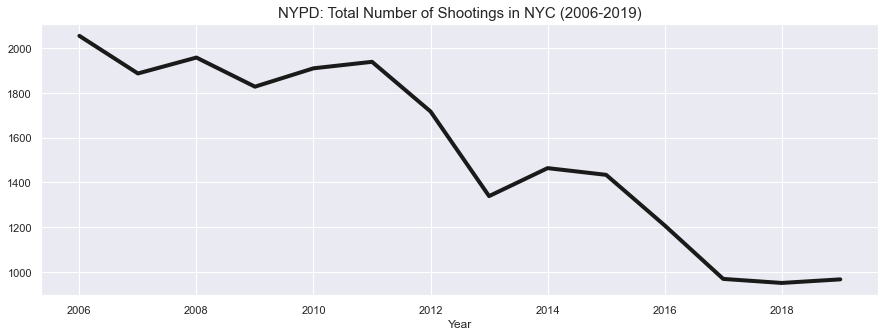

In [65]:
# Number of shootings per year: 
nyc_shootings_pivot_df.sum().plot(figsize=(15,5), linewidth=4, color=u'k')
plt.title("NYPD: Total Number of Shootings in NYC (2006-2019)", fontsize=15);


In [78]:
nyc_shootings_pivot_df.reset_index()['Borough'].value_counts()  #.loc[('Rikers_Island', slice(None))]

Queens           75
Brooklyn         67
Bronx            52
Staten_Island    48
Manhattan        36
Name: Borough, dtype: int64

In [ ]:
# nyc_shootings_percentiles_df = nyc_shootings_pivot_df.rank(axis=0, pct=True)

In [36]:
nyc_shootings_avg_df = (nyc_shootings_pivot_df.apply(lambda x: np.mean(x), axis=1)
                        .to_frame(name='Avg_Shootings')
                        .sort_values(by='Avg_Shootings'))  # .reset_index())

In [37]:
nyc_shootings_avg_df

Avg_Shootings
Borough       Neighborhood                     
Queens        Auburndale               0.071429
              Beechhurst               0.071429
Staten_Island Richmond Valley          0.071429
Queens        Bayswater                0.071429
Bronx         Riverdale                0.071429
...                                         ...
Manhattan     Central Harlem          40.285714
Brooklyn      Weeksville              45.000000
Manhattan     East Harlem             45.928571
Brooklyn      Brownsville             59.714286
              Bedford Stuyvesant      60.928571

[278 rows x 1 columns]

In [38]:
# nyc_shootings_avg_df.reset_index(drop=False)[nyc_shootings_avg_df.reset_index(drop=False)['Name'] == 'Soho']

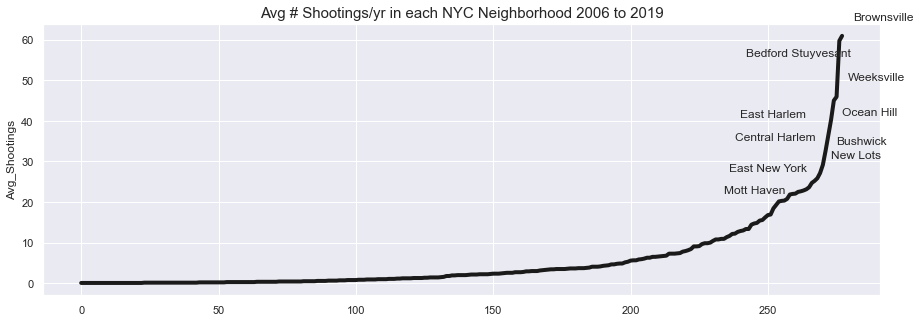

In [87]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=nyc_shootings_avg_df, x=nyc_shootings_avg_df.reset_index().index, y="Avg_Shootings",
                  linewidth=4, color=u'k');
plt.title("Avg # Shootings/yr in each NYC Neighborhood 2006 to 2019", fontsize=15);
y_offset = 5
for i, row in nyc_shootings_avg_df.reset_index()[-10:].iterrows():
    ax.annotate(str(row['Neighborhood']), (i, row['Avg_Shootings']),  # + "," + row['Borough']
                xytext=((i + 5) if y_offset > 0 else (i - 35), row['Avg_Shootings'] + y_offset))
    y_offset = -1*y_offset

In [40]:
# Less than 1 shooting per year? 

nyc_shootings_avg_df[nyc_shootings_avg_df['Avg_Shootings'] < 1]


Avg_Shootings
Borough       Neighborhood                  
Queens        Auburndale            0.071429
              Beechhurst            0.071429
Staten_Island Richmond Valley       0.071429
Queens        Bayswater             0.071429
Bronx         Riverdale             0.071429
...                                      ...
              Pelham Parkway        0.857143
Queens        Holliswood            0.928571
              Murray Hill           0.928571
Brooklyn      Carroll Gardens       0.928571
Manhattan     Hudson Yards          0.928571

[108 rows x 1 columns]

In [104]:
# Save to CSV: 
nyc_shootings_avg_df.to_csv(path_or_buf= home_path / 'NYC_Neighborhood_Shootings_Avg.csv')

In [52]:
# Calculate Trajectory: Regression Slope

shootings_trajectory_df = nyc_shootings_pivot_df.copy()
shootings_trajectory_df['Trajectory'] = shootings_trajectory_df.T.apply(lambda x: 
                                                                        np.polyfit(np.arange(len(x.values)), x.values, 1)[0])
shootings_trajectory_df = shootings_trajectory_df.sort_values(by='Trajectory', ascending=False)


In [53]:
shootings_trajectory_df

Year                              2006  2007  2008  2009  2010  2011  2012  \
Borough       Neighborhood                                                   
Queens        Queensbridge           1     0     5     5    15    10     9   
Bronx         Allerton               3     3     3     5    11     4     5   
Queens        Ravenswood             0     1     5     5     6     4     7   
Staten_Island Graniteville           0     1     1     0     1     0     0   
              New Brighton           3     1     2    15     2     5     4   
...                                ...   ...   ...   ...   ...   ...   ...   
Manhattan     Central Harlem        66    39    56    42    62    42    41   
Brooklyn      East New York         44    68    57    34    31    45    27   
              Bushwick              43    69    54    23    32    28    20   
              Brownsville           71   109    95    58    72    84    52   
              Bedford Stuyvesant    88    91    76    91    64    79    71   

Year                              2013  2014  2015  2016  2017  2018  2019  \
Borough       Neighborhood                                                   
Queens        Queensbridge           6    11     5     1     5     5    14   
Bronx         Allerton              10    10     8     4     6     9     7   
Queens        Ravenswood             1    10     3     3     5    11     4   
Staten_Island Graniteville           2     3     0     2     3     0     2   
              New Brighton          11     8     8     7     8     4     1   
...                                ...   ...   ...   ...   ...   ...   ...   
Manhattan     Central Harlem        36    32    42    43    24    15    24   
Brooklyn      East New York         20    23    38    20    14     9    27   
              Bushwick              27    31    18    20    13    19    11   
              Brownsville           54    50    48    33    28    44    38   
              Bedford Stuyvesant    57    55    43    40    35    34    29   

Year                              Trajectory  
Borough       Neighborhood                    
Queens        Queensbridge          0.320879  
Bronx         Allerton              0.320879  
Queens        Ravenswood            0.318681  
Staten_Island Graniteville          0.116484  
              New Brighton          0.112088  
...                                      ...  
Manhattan     Central Harlem       -2.694505  
Brooklyn      East New York        -3.061538  
              Bushwick             -3.098901  
              Brownsville          -4.707692  
              Bedford Stuyvesant   -5.079121  

[278 rows x 15 columns]

In [107]:
# Save to CSV: 
shootings_trajectory_df.to_csv(path_or_buf= home_path / 'NYC_Neighborhood_Shootings_Trajectory.csv')

In [38]:
# Alternative: Use Google Maps Directions to Calc distance instead? 

def gmaps_directions(my_gmaps_key, start_lat, start_long, destination_lat, destination_long):
    # 'https://maps.googleapis.com/maps/api/directions/json?parameters'
    
    # Build URL:
    gmaps_url = 'https://maps.googleapis.com/maps/api/directions/json?'
    
    gmaps_url += "&origin={},{}".format(str(start_lat), str(start_long))
    gmaps_url += "&destination={},{}".format(str(destination_lat), str(destination_long))
    
    gmaps_url += "&key={}".format(my_gmaps_key)
    
    return requests.get(gmaps_url).json()

In [69]:
# From Google Maps: 
"""
mapped_neighborhoods_dict = {}  # Key: Shooting_Index, Value: ('Borough','Neighborhood')
by_shooting_all_deighborhood_dist_list = []  # List of df's with distanace from shooting to each neighborhood 

# Outer Loop: Shooting Incidents
for shooting_index in nyc_shootings_raw_df.index:
    start_lat = nyc_shootings_raw_df.iloc[shooting_index]['Latitude']
    start_long = nyc_shootings_raw_df.iloc[shooting_index]['Longitude']
    
    distances_dict = {}
    # Inner Loop: Calc distance to each Neighborhood, & pick closest:
    
    # To Do:
    # search_borough = nyc_shootings_raw_df.iloc[shooting_index]['BORO']
    # Filter neighborhood_df by search_borough: 
    
    for neighborhood_index in neighborhood_df.index: 
        destination_lat = neighborhood_df.iloc[neighborhood_index]['Lat']
        destination_long = neighborhood_df.iloc[neighborhood_index]['Long']
        
        distance_json = gmaps_directions(my_gmaps_key, start_lat, start_long, destination_lat, destination_long)
        try:
            distances_dict[neighborhood_index] = round(
                distance_json['routes'][0]['legs'][0]['distance']['value'] / 1610, # meters to miles
                2)  
        except:
            distances_dict[neighborhood_index] = 999
    # Join Together & Pick Min
    incident_df= neighborhood_df.copy()
    incident_df = incident_df.join(pd.DataFrame.from_dict(distances_dict, 
                                                          orient='index', columns=['Distance_miles']))
    by_shooting_all_deighborhood_dist_list.append(incident_df)
    mapped_neighborhoods_dict[shooting_index] = incident_df.loc[incident_df['Distance_miles'].idxmin()]
mapped_neighborhoods_df = pd.DataFrame.from_dict(mapped_neighborhoods_dict, orient='index') 
"""

"\nmapped_neighborhoods_dict = {}  # Key: Shooting_Index, Value: ('Borough','Neighborhood')\nby_shooting_all_deighborhood_dist_list = []  # List of df's with distanace from shooting to each neighborhood \n\n# Outer Loop: Shooting Incidents\nfor shooting_index in nyc_shootings_raw_df.index:\n    start_lat = nyc_shootings_raw_df.iloc[shooting_index]['Latitude']\n    start_long = nyc_shootings_raw_df.iloc[shooting_index]['Longitude']\n    \n    distances_dict = {}\n    # Inner Loop: Calc distance to each Neighborhood, & pick closest:\n    \n    # To Do:\n    # search_borough = nyc_shootings_raw_df.iloc[shooting_index]['BORO']\n    # Filter neighborhood_df by search_borough: \n    \n    for neighborhood_index in neighborhood_df.index: \n        destination_lat = neighborhood_df.iloc[neighborhood_index]['Lat']\n        destination_long = neighborhood_df.iloc[neighborhood_index]['Long']\n        \n        distance_json = gmaps_directions(my_gmaps_key, start_lat, start_long, destination_lat, 